Multiple Linear Regression
==========================
"f(x) = b + w1X1 + w2X2 + ... + wnXn

w = [w1, w2, ..., wn]
b is a number
X = [X1, X2, ..., Xn]
=> f(x) = b + w.X, where w and X are vectors and . represents dot product

Prepare Data

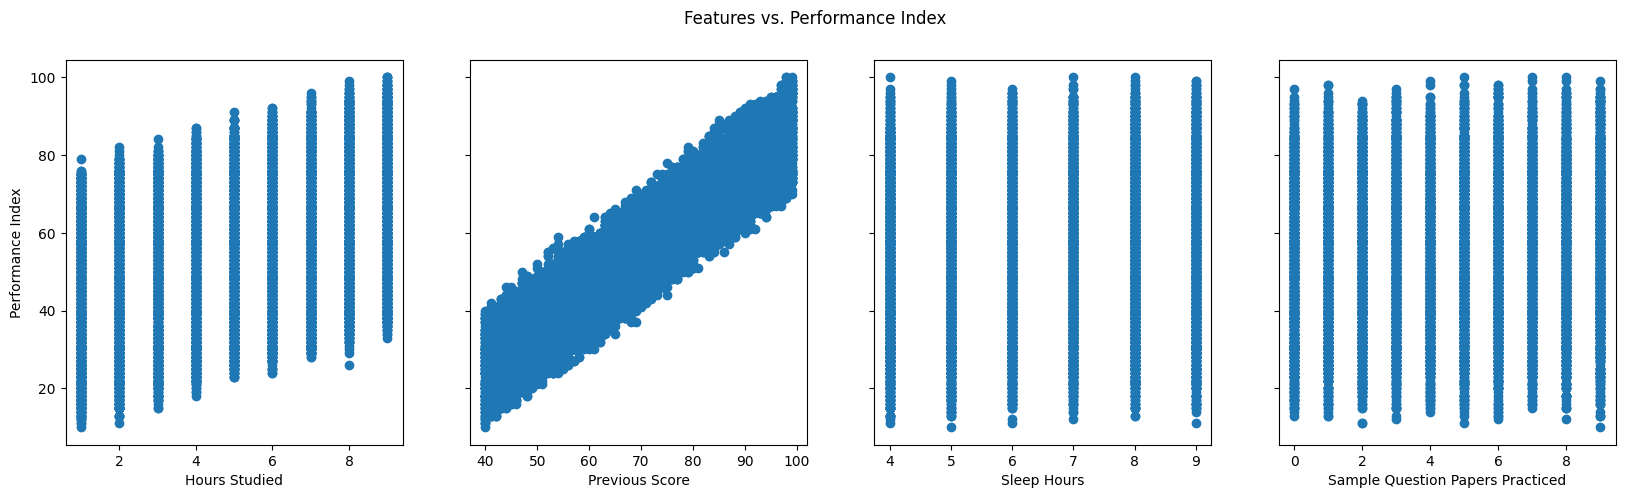

In [18]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# load csv data
data = np.genfromtxt('../Student_Performance.csv', delimiter=',', skip_header=1)

# drop rows with missing values
data = data[~np.isnan(data).any(axis=1)]

# split data into X and y
X = data[:, :-1]
y = data[:, -1]

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_labels = ['Hours Studied', 'Previous Score', 'Sleep Hours', 'Sample Question Papers Practiced']
# plot each feature against y
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_train_labels[i])
ax[0].set_ylabel('Performance Index')
fig.suptitle('Features vs. Performance Index')
plt.show()

Cost Function
=============
J(w, b) = 1/2m * sum((f(x) - y)^2)

In [5]:
def compute_cost(X, y, w, b):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + (f_wb_i - y[i]) ** 2
    cost = cost / (2 * m)
    return cost

Gradient Descent
================
w = w - alpha * dJ(w, b)/dw
b = b - alpha * dJ(w, b)/db

where dJ(w, b)/dw = 1/m * sum((f(x) - y) * x)
and dJ(w, b)/db = 1/m * sum(f(x) - y)

In [6]:
def compute_gradient(X, y, w, b):
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw


def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  # avoid modifying global w within function
    b = b_in

    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i < 100000:  # prevent resource exhaustion 
            J_history.append(cost_function(X, y, w, b))

    return w, b, J_history

Test with Test Data
=======

w: [ 0.64470287  0.7847001  -0.16835938 -0.07145702]
b: -0.03787927961857221
Time taken: 36.75565147399902 seconds


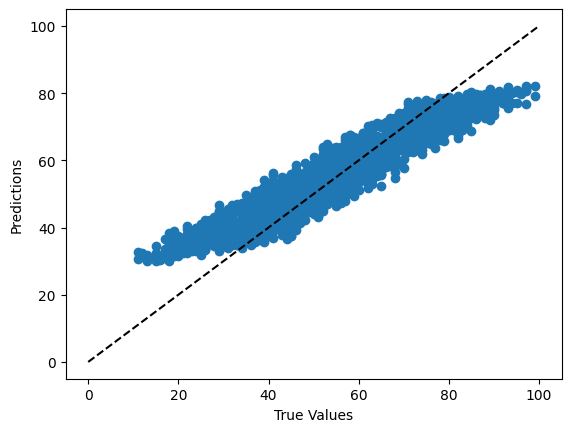

Cost on test data: 28.14280171003217


In [11]:
initial_w = np.zeros(X_train.shape[1])
initial_b = 0

# play around with iterations and alpha
iterations = 500
alpha = 0.0001

start = time.time()
w, b, J_history = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha,
                                   iterations)
end = time.time()

print(f'w: {w}')
print(f'b: {b}')
print(f'Time taken: {end - start} seconds')

y_pred = np.dot(X_test, w) + b

# plot y_test vs y_pred and x=y line
plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0, 100], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# calculate cost on test data
cost = compute_cost(X_test, y_test, w, b)
print(f'Cost on test data: {cost}')

P.S: some libraries use the "normal equation" to solve for w and b. The normal equation is a closed-form solution that directly computes the parameters that minimize the cost function.

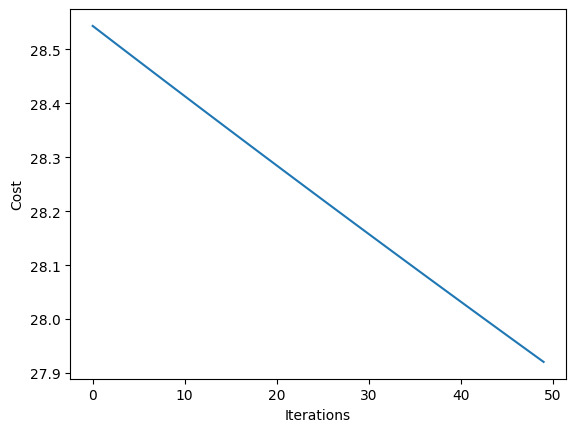

In [19]:
# plot cost vs. iterations for last 50 iterations
plt.plot(J_history[-50:])
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Note that the cost is still decreasing. We will explore more on this later.

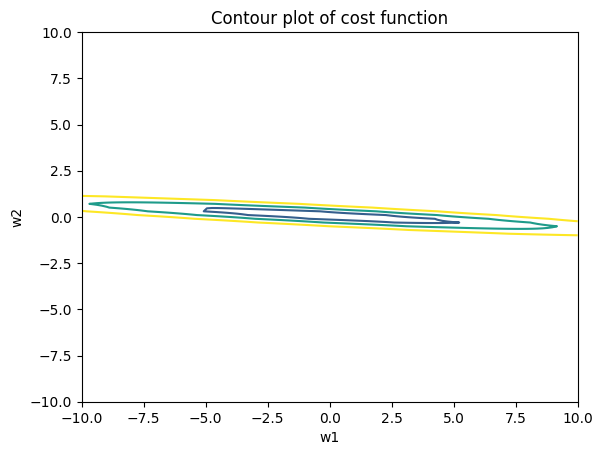

In [25]:
# plot contour plot of cost function, for the first two features
w1_vals = np.linspace(-10, 10, 100)
w2_vals = np.linspace(-10, 10, 100)

J_vals = np.zeros((len(w1_vals), len(w2_vals)))
for i, w1 in enumerate(w1_vals):
    for j, w2 in enumerate(w2_vals):
        w = np.array([w1, w2])
        J_vals[i, j] = compute_cost(X_train[:, :2], y_train, w, b)
        
plt.contour(w1_vals, w2_vals, J_vals.T, levels=np.logspace(-2, 3, 20))
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Contour plot of cost function')
plt.show()

Notice how narrow the contour plot is. This is because the features have different ranges.
We will address this in the next section.

Feature Scaling
===============
When the possible values of features differ by orders of magnitude (e.g., one feature ranges from 0 to 1 and another ranges from 1 to 1000), it is likely that the 'w' values will also differ by orders of magnitude.
The contour plot of the cost function will be narrow on the side of the feature with the larger range and wider on the side of the feature with the smaller range.
In this case, the algorithm will take longer to converge.

To address this, we can normalize the features to have similar ranges.
Then, the contour plot of the cost function will be more symmetric and the algorithm will converge faster.

Normalization approaches:
1. divide by maximum: x = x / max  OR  x = (x - min) / (max - min)
2. mean normalization: x = (x - mean) / (max - min)     ----> -1 <= x <= 1
3. z-score normalization: x = (x - mean) / std      ----> mean = 0, std = 1

mean = 1/m * sum(x)
std = sqrt(1/m * sum(x - mean)^2)

As a rule of thumb, aim for -1 <= x <= 1

Note: when in doubt, rescale the features.

In [7]:
def z_score_normalization(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

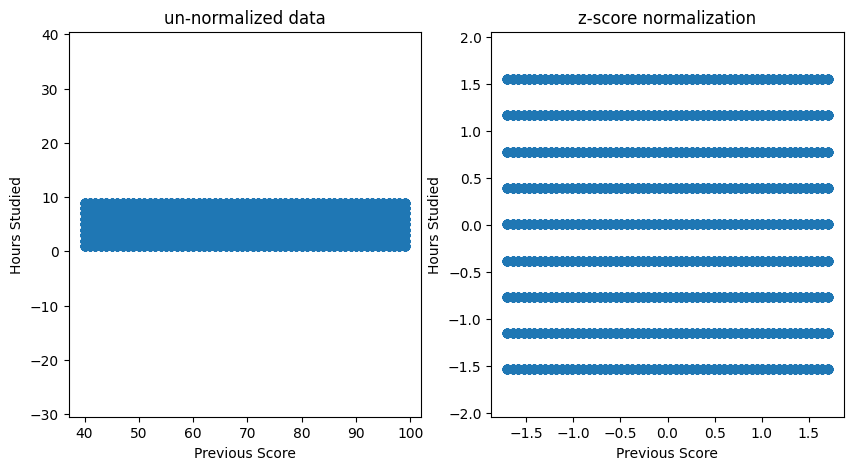

In [9]:
# perform scaling
X_train_norm, mu, sigma = z_score_normalization(X_train)

# plot the first and second features
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X_train[:, 1], X_train[:, 0])
ax[0].set_xlabel(X_train_labels[1]); ax[0].set_ylabel(X_train_labels[0])
ax[0].set_title('un-normalized data')
ax[0].axis('equal')

ax[1].scatter(X_train_norm[:, 1], X_train_norm[:, 0])
ax[1].set_xlabel(X_train_labels[1]); ax[1].set_ylabel(X_train_labels[0])
ax[1].set_title('z-score normalization')
ax[1].axis('equal')

plt.show()

In [10]:
print(f'mu: {mu}')
print(f'sigma: {sigma}')

mu: [ 4.98325  69.531     6.541625  4.6165  ]
sigma: [ 2.59470026 17.34265086  1.69838669  2.86106235]


In [12]:
# re-run gradient descent with normalized features
initial_w = np.zeros(X_train_norm.shape[1])
initial_b = 0

iterations = 500
alpha = 0.1     # alpha = 0.1 is a good start for normalized features

start = time.time()
w, b, J_history = gradient_descent(X_train_norm, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha,
                                   iterations)
end = time.time()

print(f'w: {w}')
print(f'b: {b}')
print(f'Time taken: {end - start} seconds')

# TODO: why is it taking so long?

w: [ 7.40240354 17.63809533  0.80387754  0.54854088]
b: 55.311499999999974
Time taken: 34.66021466255188 seconds


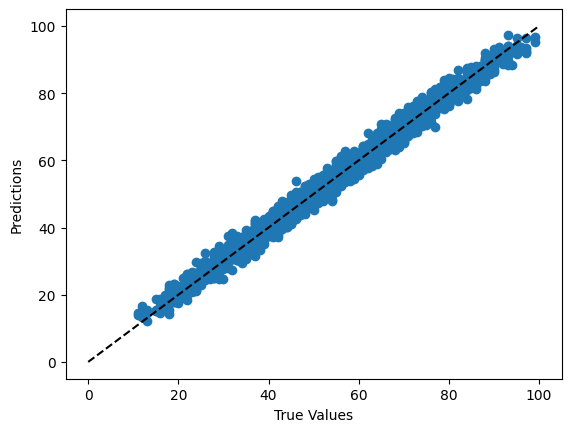

In [13]:
# predict on test data
X_test_norm = (X_test - mu) / sigma
y_pred = np.dot(X_test_norm, w) + b

# plot y_test vs y_pred and x=y line
plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0, 100], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

Notice that the predictions are closer to the line x=y!

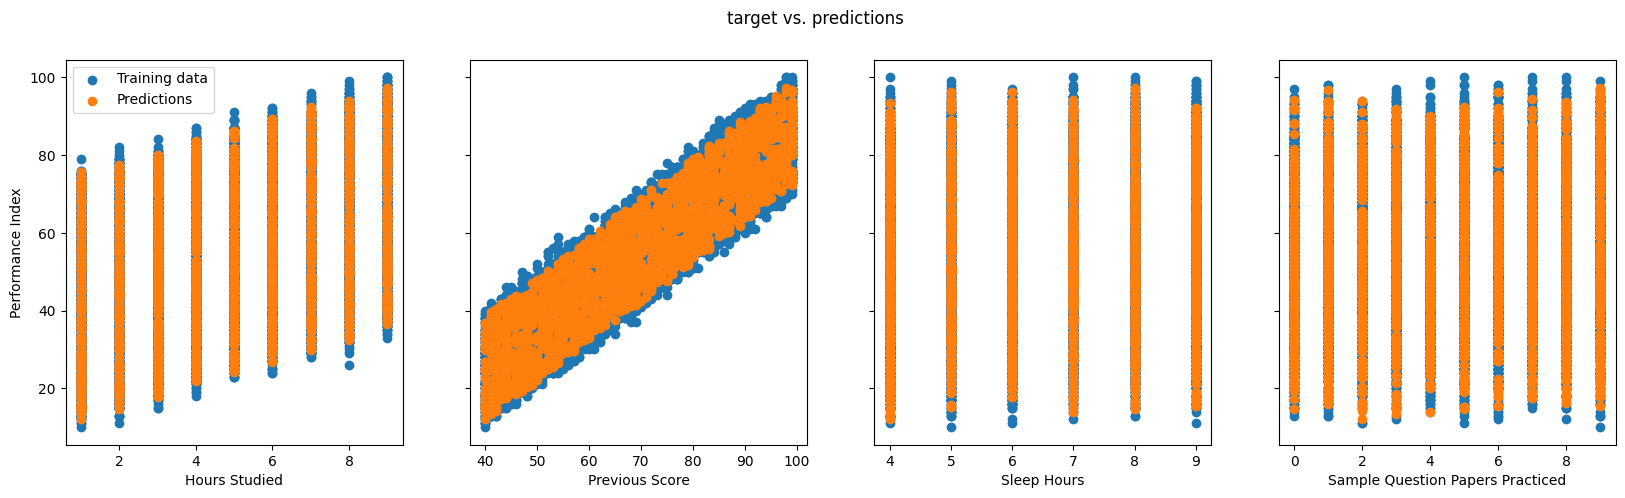

In [20]:
# plot predictions and targets vs. features
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i], y_train, label='Training data')
    ax[i].set_xlabel(X_train_labels[i])
    # predictions
    ax[i].scatter(X_test[:,i], y_pred, label='Predictions')
ax[0].set_ylabel('Performance Index')
ax[0].legend()
fig.suptitle('target vs. predictions')
plt.show()

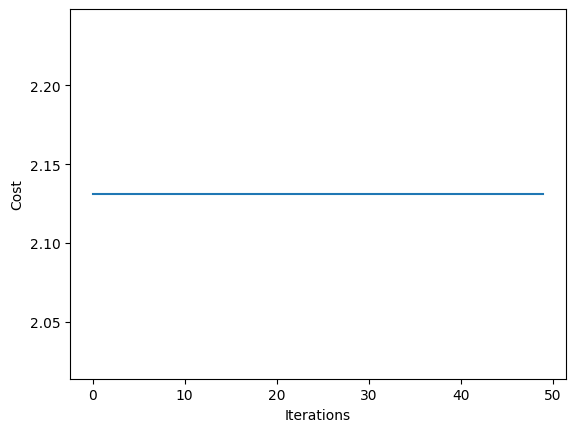

In [22]:
# Plot cost function in the last 50 iterations
plt.plot(J_history[-50:])
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Notice that the cost is much less than before. This is because the features are normalized.

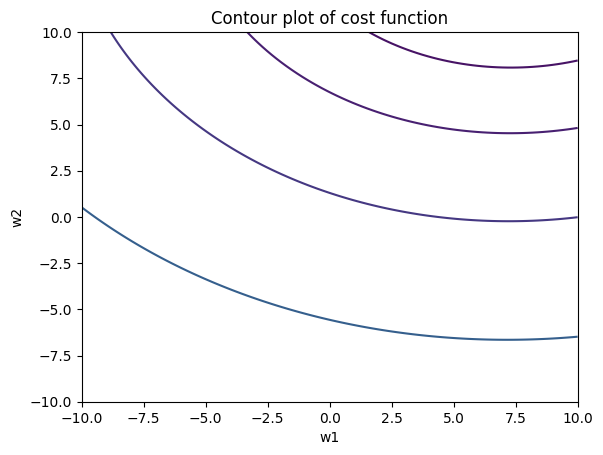

In [24]:
# plot contour plot of cost function, for the first two features
# we can see that the contour plot is more symmetric
w1_vals = np.linspace(-10, 10, 100)
w2_vals = np.linspace(-10, 10, 100)

J_vals = np.zeros((len(w1_vals), len(w2_vals)))
for i, w1 in enumerate(w1_vals):
    for j, w2 in enumerate(w2_vals):
        w = np.array([w1, w2])
        J_vals[i, j] = compute_cost(X_train_norm[:, :2], y_train, w, b)
        
plt.contour(w1_vals, w2_vals, J_vals.T, levels=np.logspace(-2, 3, 20))
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Contour plot of cost function')
plt.show()

Now the plot is more symmetric, and the algorithm converges faster.

Choosing alpha and checking convergence
=======================================
We can use the cost function to determine if the algorithm has converged.
The cost function - or learning curve - should decrease with each iteration.
If the cost function is not decreasing, we may need to adjust the learning rate alpha.

Another way to check for convergence is to set a threshold for the difference in cost between iterations.
If the difference is less than the threshold, the algorithm has converged.

You can start with an initial value of alpha, and then triple it each time.
By plotting the cost function, you can choose the largest possible alpha that still converges.